In [13]:
#Contains all imports and functions

import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework import ops
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import cv2
import os
import tensorflowjs as tfjs

%matplotlib inline

    
def convert_to_one_hot(Y, C):
    Y = Y.astype(int)
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
    
def show_last_nine():   #disaply last 9 randomised images in most recently loaded set
    print('Display last nine test images')
    c = 0;
    for i in range(y_test.shape[0]-9, y_test.shape[0]):
        #3 digit number represents row, col, pos
        plt.subplot(331 + c)
        plt.imshow(x_test[i]/255)
        print(vals[int(y_test[i])], end=" ")
        c+=1
    plt.show()
    
def load_data(start, end, rand_ord):
    print('Start ' + str(start) + ' End ' + str(end) + '/' + str(samples) + ' and their mirrors')
    this_size = end - start
    xdata = np.zeros((this_size, w, h, 3))      #Initialise arrays
    ydata = np.zeros(this_size)
    for i in range(start, end):  #Groups of size mini_batch_size
        im_details = image_details[rand_ord[i]]    #folder name, value position(1, 2, 3 == a, b, c etc), image number
        
        #Read images, convert to array and populate temp array
        img = load_img(im_details[0] + '/' + str(vals[im_details[1]]) + str(im_details[2]) + '.png', target_size=(w, h))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        xdata[i-start] = x
        ydata[i-start] = im_details[1] 
    xdata = np.concatenate((xdata, np.flip(xdata, 2)), axis=0)   #Add mirrored images to end of array
    ydata = np.concatenate((ydata, ydata))                       #Copy ydata twice
    return xdata, ydata
    
    #improve speed by saving entire image set as hdf5 then loading in parts
def load_incrementally_and_train(model_name):
    print('Randomised order ')
    print(random_order)  
    print('Number of samples ' + str(samples))
    print('Number of train samples ' + str(train_size))
    print('Number of test samples ' + str(test_size))
    
    print('===Train===')
    for m in range(groups):    #Load training images in groups and train model
        x_data, y_data = load_data(m*mini_batch_size, (m+1)*mini_batch_size, random_order)
        #model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T)
        model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T, validation_split=0.1)
    
    #Load last set of training samples. Group of size mini_batch_size or less
    x_data, y_data = load_data(groups*mini_batch_size, train_size, random_order)
    model_name.fit(x_data, convert_to_one_hot(y_data, num_of_classes).T, validation_split=0.1)
    print('Model has been trained')
        
    #Load test samples
    print('===Test===')
    x_data, y_data = load_data(train_size, samples, random_order)
    model.evaluate(x_data,  convert_to_one_hot(y_data, num_of_classes).T, verbose=2)
    print(' ')
    return x_data, y_data, model  #Returns trained model and test dataset in case more testing needed

def order_folders():
    camcl = []
    for i in range(0, len(im_folder)):
        for j in range(0, im_folder[i][1]*num_of_classes):
            camcl.append([im_folder[i][0], np.floor(j/im_folder[i][1]).astype(int), j%im_folder[i][1]])
    return camcl

In [19]:
w = 200
h = 200
vals = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','SPACE']

num_of_classes = len(vals)
eps = 15

im_folder = []
im_folder.append(['images/images200x200', 50])
im_folder.append(['images/images2', 50])
im_folder.append(['images/images3', 50])

image_details = order_folders()   #Stores folder name, letter and number label of each image
test_percentage = 0.1

#Process images
samples = len(image_details)    #Number of images available
test_size = round(samples*test_percentage)   #Number of testing samples
train_size = samples - test_size             #Number of training samples
mini_batch_size = 850                       #data samples loaded at once
groups = int(np.ceil(train_size/mini_batch_size)-1)    #number of iterations before final. Last one is likely not exactly mini_batch_size   

#create list of randomised numbers 0 to data_size
random_order = np.arange(samples)
np.random.shuffle(random_order)

# ==with dropout==
model = Sequential()
model.add(Conv2D(filters=16, strides=(1, 1), kernel_size=5, padding='same', activation='relu', input_shape=(w, h, 3))) 
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, strides=(1, 1), kernel_size=5, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.3))
model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=3, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 

model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))
model.compile(lr=0.000001, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#SIMPLIFIED
# model = Sequential()
# model.add(Conv2D(filters=32, strides=(1, 1), kernel_size=3, padding='same', activation='relu', input_shape=(w, h, 3))) 
# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Conv2D(filters=64, strides=(1, 1), kernel_size=3, padding='same', activation='relu')) 

# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 

# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Conv2D(filters=128, strides=(1, 1), kernel_size=2, padding='same', activation='relu')) 

# model.add(MaxPooling2D(pool_size=2, padding='same'))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_of_classes, activation='softmax'))
# model.compile(lr=0.01, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 200, 200, 16)      1216      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      12832     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)       

Epoch 1/20
Randomised order 
[3884  638 1007 ...  662 1643 2857]
Number of samples 4050
Number of train samples 3645
Number of test samples 405
===Train===
Start 0 End 850/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 3s 2ms/sample - loss: 44.2967 - acc: 0.0464 - val_loss: 3.2943 - val_acc: 0.0353
Start 850 End 1700/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 3.2960 - acc: 0.0314 - val_loss: 3.2935 - val_acc: 0.0294
Start 1700 End 2550/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 3.2964 - acc: 0.0405 - val_loss: 3.2953 - val_acc: 0.0412
Start 2550 End 3400/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 3.2967 - acc: 0.0346 - val_loss: 3.2946 - val_

Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 2.3921 - acc: 0.3131 - val_loss: 2.4979 - val_acc: 0.2824
Start 850 End 1700/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 2.1887 - acc: 0.3503 - val_loss: 2.2125 - val_acc: 0.3412
Start 1700 End 2550/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 2.0887 - acc: 0.3863 - val_loss: 2.2349 - val_acc: 0.3824
Start 2550 End 3400/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 1.8256 - acc: 0.4405 - val_loss: 2.0257 - val_acc: 0.3706
Start 3400 End 3645/4050 and their mirrors
Train on 441 samples, validate on 49 samples
441/441 [==============================] - 1s 1ms/sample - loss: 1.7757 - acc: 0.4762 - val_loss

Start 850 End 1700/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.2081 - acc: 0.9275 - val_loss: 0.2823 - val_acc: 0.9059
Start 1700 End 2550/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.2188 - acc: 0.9281 - val_loss: 0.3172 - val_acc: 0.9059
Start 2550 End 3400/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.1943 - acc: 0.9346 - val_loss: 0.3167 - val_acc: 0.8941
Start 3400 End 3645/4050 and their mirrors
Train on 441 samples, validate on 49 samples
441/441 [==============================] - 1s 1ms/sample - loss: 0.2179 - acc: 0.9365 - val_loss: 0.2179 - val_acc: 0.9388
Model has been trained
===Test===
Start 3645 End 4050/4050 and their mirrors
810/1 - 1s - loss: 0.2646 - acc: 0.9037
 
Epoch 14/20
Randomised ord

1530/1530 [==============================] - 2s 1ms/sample - loss: 0.0743 - acc: 0.9758 - val_loss: 0.1650 - val_acc: 0.9647
Start 1700 End 2550/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.0986 - acc: 0.9667 - val_loss: 0.1996 - val_acc: 0.9235
Start 2550 End 3400/4050 and their mirrors
Train on 1530 samples, validate on 170 samples
1530/1530 [==============================] - 2s 1ms/sample - loss: 0.1412 - acc: 0.9529 - val_loss: 0.1835 - val_acc: 0.9471
Start 3400 End 3645/4050 and their mirrors
Train on 441 samples, validate on 49 samples
441/441 [==============================] - 1s 1ms/sample - loss: 0.1010 - acc: 0.9728 - val_loss: 0.1091 - val_acc: 0.9796
Model has been trained
===Test===
Start 3645 End 4050/4050 and their mirrors
810/1 - 1s - loss: 0.1142 - acc: 0.9519
 
Epoch 20/20
Randomised order 
[3884  638 1007 ...  662 1643 2857]
Number of samples 4050
Number of train samples 36

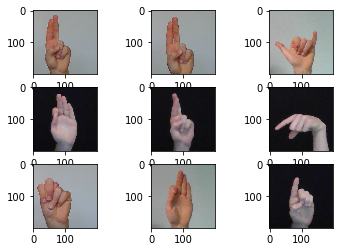

In [20]:
#This file is used when training data is too big. Loads data in batches. Fit function still returns test data as much 
#smaller and gives reference for correct processing. Should be able to be called multiple times to increase epochs.
eps = 20
for i in range(eps):
    print('Epoch ' + str(i+1) + '/' + str(eps))
    x_test, y_test, model = load_incrementally_and_train(model)
show_last_nine()

              precision    recall  f1-score   support

           A       1.00      0.94      0.97        34
           B       0.86      0.90      0.88        42
           C       0.86      1.00      0.92        18
           D       0.97      0.94      0.95        32
           E       0.94      1.00      0.97        32
           F       0.93      0.86      0.89        44
           G       1.00      0.90      0.95        20
           H       1.00      1.00      1.00        30
           I       0.95      1.00      0.97        38
           J       0.91      1.00      0.95        30
           K       1.00      1.00      1.00        20
           L       0.96      1.00      0.98        22
           M       0.92      0.96      0.94        24
           N       0.89      0.91      0.90        34
           O       1.00      1.00      1.00        26
           P       1.00      0.95      0.98        22
           Q       1.00      0.94      0.97        34
           R       0.86    

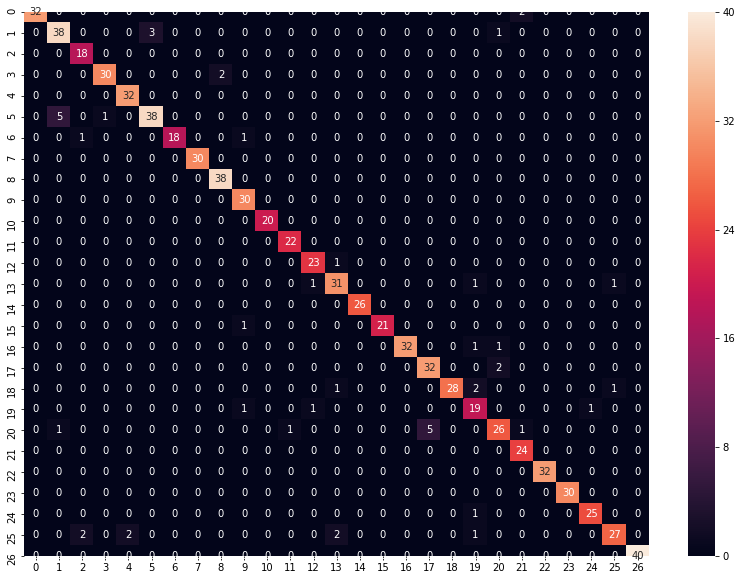

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# get the predictions for the test data
predicted_classes = model.predict_classes(x_test)

cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize = (14,10))
sns.heatmap(cm, annot=True)

from sklearn.metrics import classification_report

num_classes = 27
target_names = ["{}".format(vals[i]) for i in range(num_of_classes)]

print(classification_report(y_test, predicted_classes, target_names = target_names))

In [22]:
#=====Save model for use in tfjs
tfjs.converters.save_keras_model(model, 'tf_models/a-zMultiMirrored_0')

2700
26.0


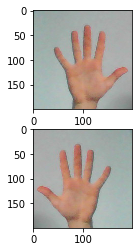

26.0
Mirroring works!


In [12]:
A = x_test  #Test mirrored images
B = y_test
print(len(A))
print(B[3])
plt.subplot(211)
plt.imshow(A[3]/255)   
plt.subplot(212)
plt.imshow(A[1353]/255)   
plt.show()
print(B[1353])

print('Mirroring works!')